In [4]:
import warnings 
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

import statsmodels.formula.api as smf 
import statsmodels.tsa.api as smt 
import statsmodels.api as sm 
import scipy.stats as scs
%matplotlib inline


In [5]:
ads = pd.read_csv('ads.csv', index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv('currency.csv', index_col=['Time'], parse_dates=['Time'])

In [6]:
ads.head()

,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


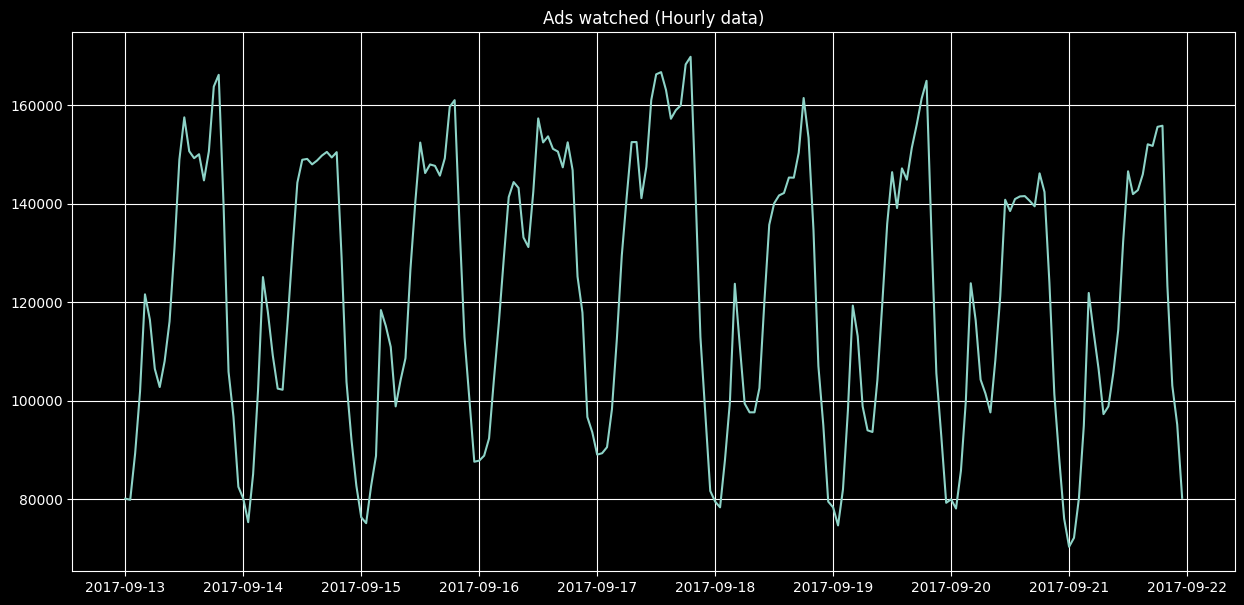

In [7]:
plt.figure(figsize=(15,7))
plt.plot(ads.Ads)
plt.title('Ads watched (Hourly data)')
plt.grid(True)
plt.show()

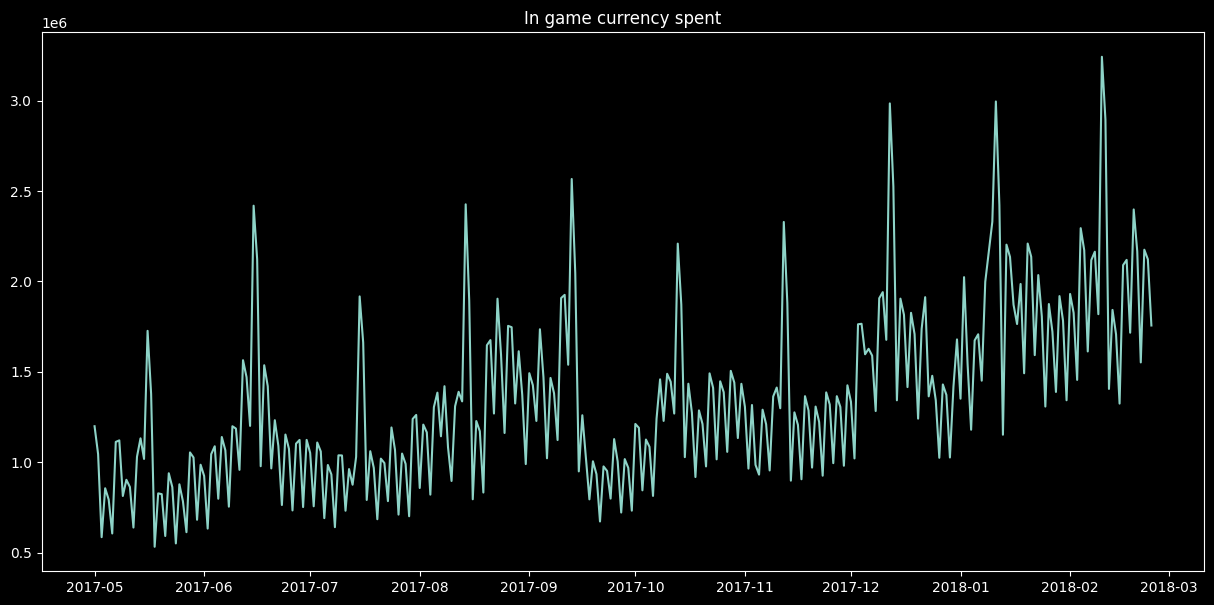

In [8]:
plt.figure(figsize=(15,7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('In game currency spent')
# plt.grid(True)
plt.show()

# Forecast Quality Metrics

- [Mean Absolute Error]

$MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$

- [Mean Squared Error]

$MSE = \frac{\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2}{n}$

In [9]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred)/y_true)) * 100

# Smoothe, Elevate & Move

* Moving Average

- Most basic hypothesis
$\hat{y}_{t} = y_{t-1}$

- Improvement : Rolling Average
$\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} y_{t-n}$

(Pandas: DataFrame.rolling(window).mean())

In [10]:
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(ads, 24)

116805.0

In [11]:
def plotMovingAverage(series, window, plot_intervals = False, scale = 1.96, plot_anomalies = False):
    rolling_mean = series.rolling(window=window).mean()
    plt.figure(figsize=(15,5))
    plt.title(f"Moving average window size = {window}")
    plt.plot(rolling_mean, "y", label="Rolling mean trend")

    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, "r--", label = "Upper Bound/Lower Bound")
        plt.plot(lower_bound, "r--")

        if plot_anomalies:
            anomalies = pd.DataFrame(index = series.index, columns = series.columns)
            anomalies[series<lower_bound] = series[series<lower_bound]
            anomalies[series>upper_bound] = series[series>upper_bound]
            plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:], label = "Actual Values")
    plt.legend(loc = "upper left")
    plt.grid(True)

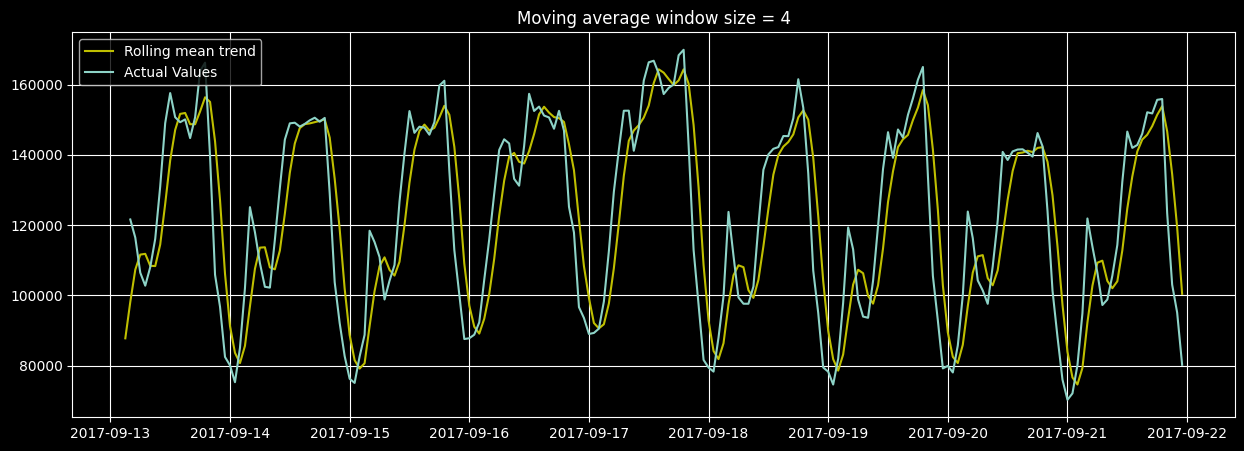

In [12]:
plotMovingAverage(ads, 4)

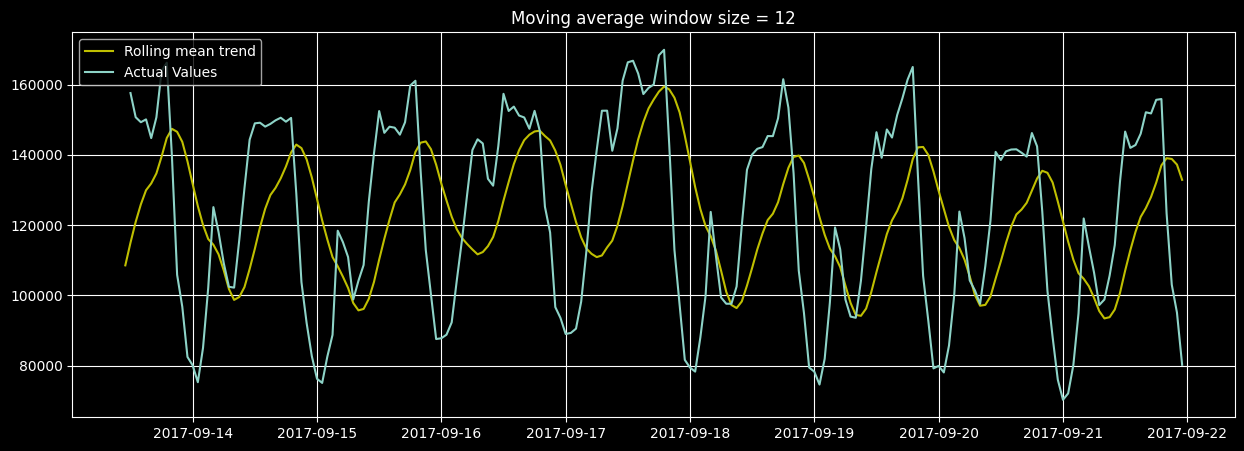

In [13]:
plotMovingAverage(ads, 12)

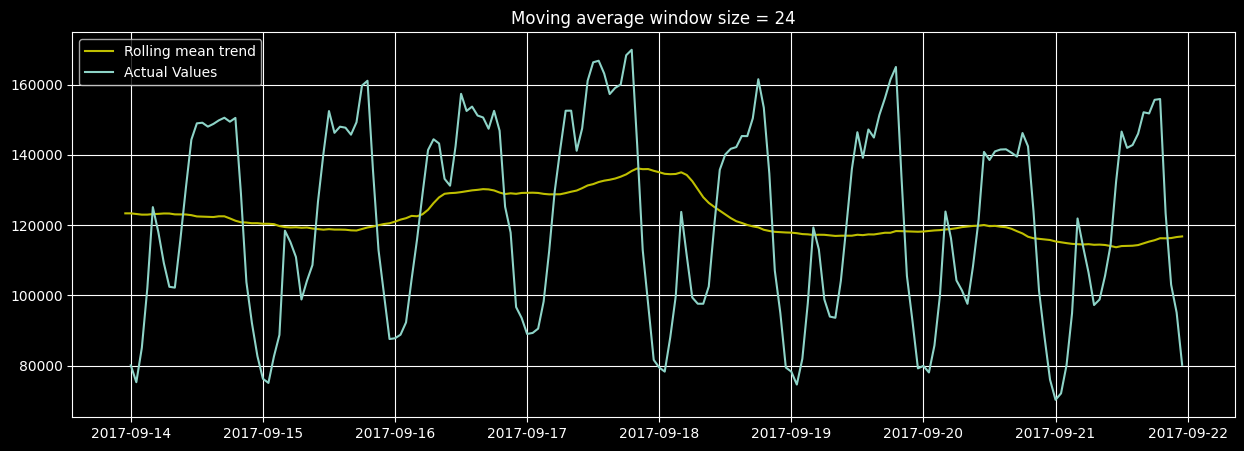

In [14]:
plotMovingAverage(ads, 24)

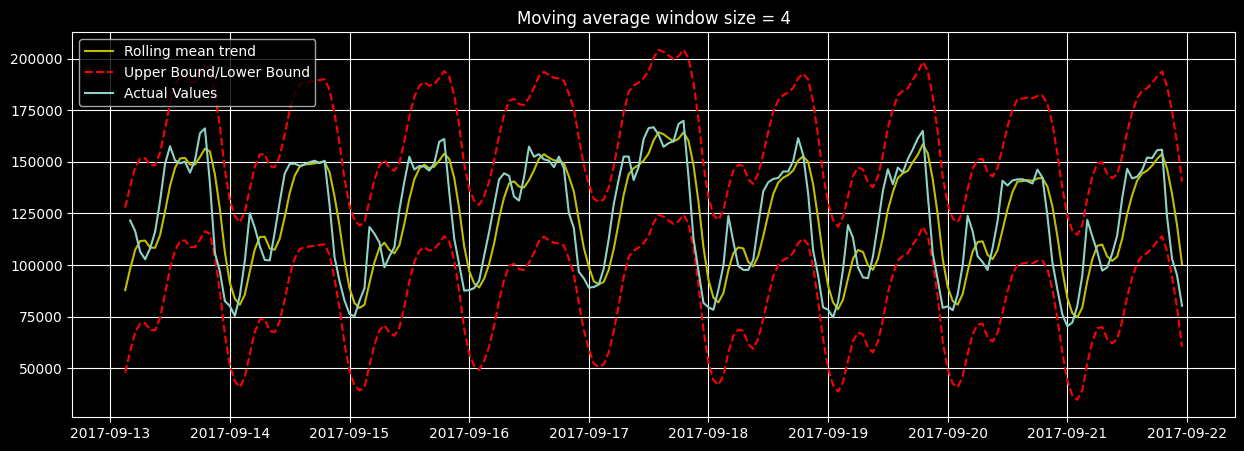

In [15]:
plotMovingAverage(ads, 4, plot_intervals=True)

In [16]:
ads_anomaly = ads 
ads_anomaly.iloc[-20] = ads_anomaly.iloc[-20] * 0.2

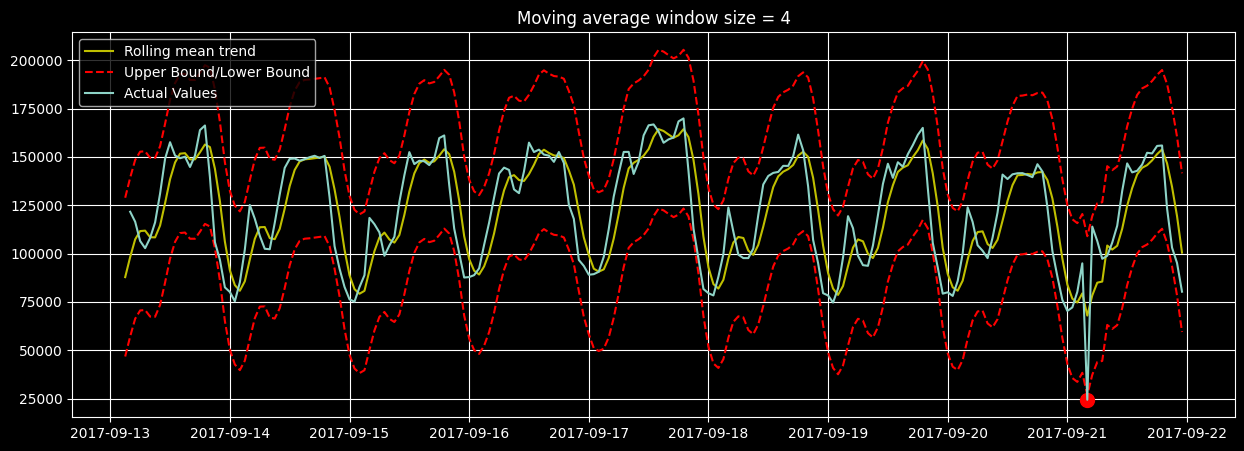

In [17]:
plotMovingAverage(ads_anomaly, 4, plot_intervals=True, plot_anomalies=True)

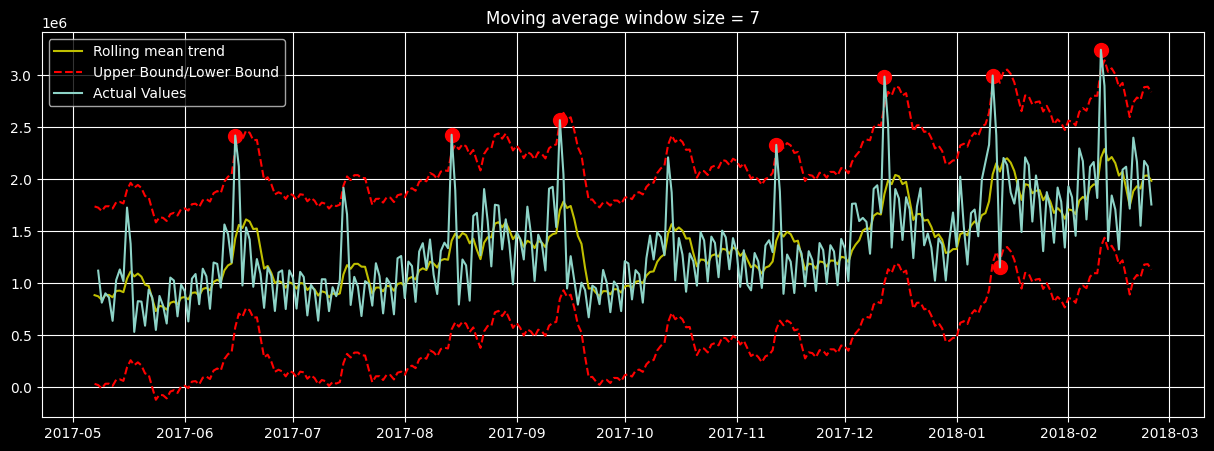

In [18]:
plotMovingAverage(currency, 7, plot_intervals=True, plot_anomalies=True)

# Exponential Smoothing

$\hat{y}_{t} = \alpha \cdot y_t + (1 - \alpha) \cdot \hat y_{t-1}$

In [19]:
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for i in range(1, len(series)):
        result.append(alpha * series[i] + (1 - alpha) * result[i-1])
    return result

In [31]:
def plotExponentialSmoothing(series, alphas):
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(15,7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label = f"Alpha {alpha}")
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc = 'best')
        plt.axis('tight')
        plt.title('Exponential Smoothing')
        plt.grid(True)

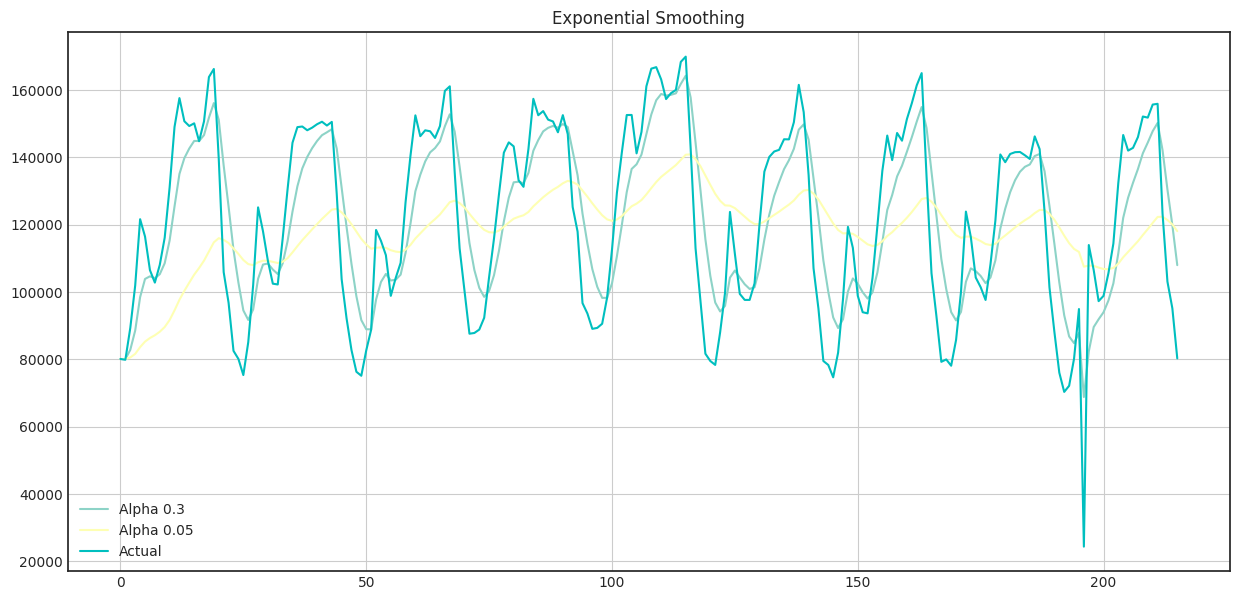

In [34]:
plotExponentialSmoothing(ads.Ads, [0.3, 0.05])

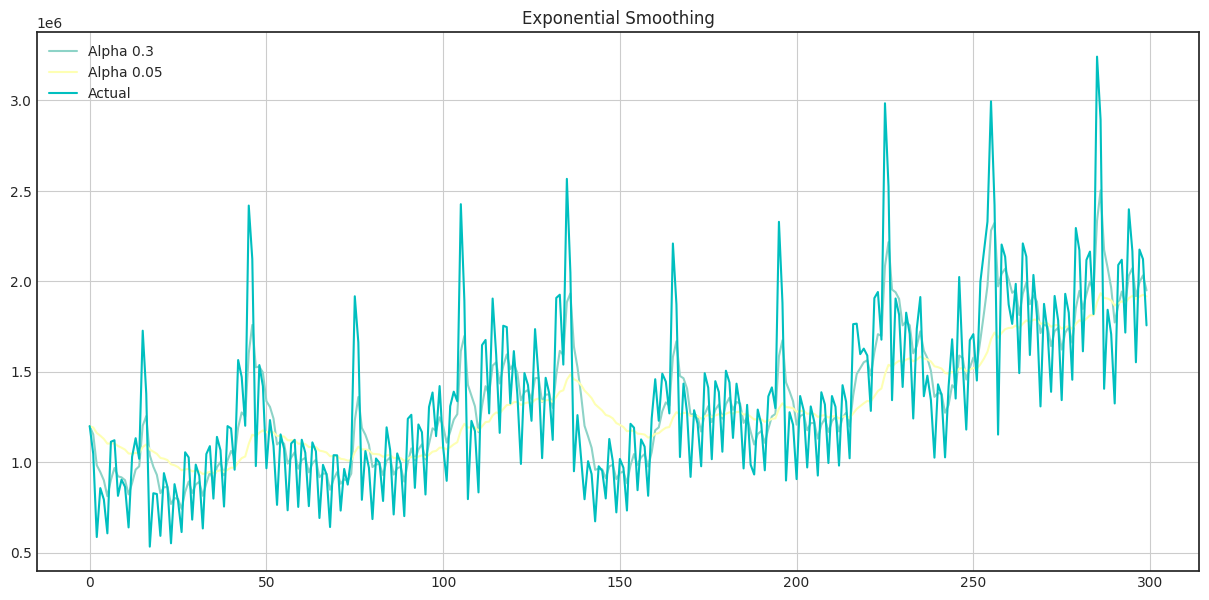

In [24]:
plotExponentialSmoothing(currency.GEMS_GEMS_SPENT, [0.3, 0.05])

# Double Exponential Smoothing

Intercept (l) and Trend(b) Calculation:

$$\ell_x = \alpha y_x + (1 - \alpha) (\ell_{x-1} + b_{x-1})$$

$$b_x = \beta (\ell_x - \ell_{x-1}) + (1- \beta)b_{x-1}$$

$$\hat{y}_{x+1} = \ell_x + b_x $$

$\alpha$ is responsible for the series smoothening around the trend whereas $\beta$ is responsible for smoothening the trend itself. 

In [35]:
def double_exponential_smoothing(series, alpha, beta) :
    result = [series[0]]
    for n in range(1, len(series) + 1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series):
            value = result[-1]
        else:
            value = series[n]

        last_level, level = level, alpha * value + (1- alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * (trend)
        result.append(level + trend)
    return result 
    

In [38]:
def plotDoubleExponentialSmoothing(series, alphas, betas):
    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(15,7))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label = f"Alpha : {alpha} Beta : {beta}")
        plt.plot(series.values, "b", label = "Actual")
        plt.legend(loc = 'best')
        plt.axis('tight')
        plt.title('Double Exponential Smoothing')
        plt.grid(True)

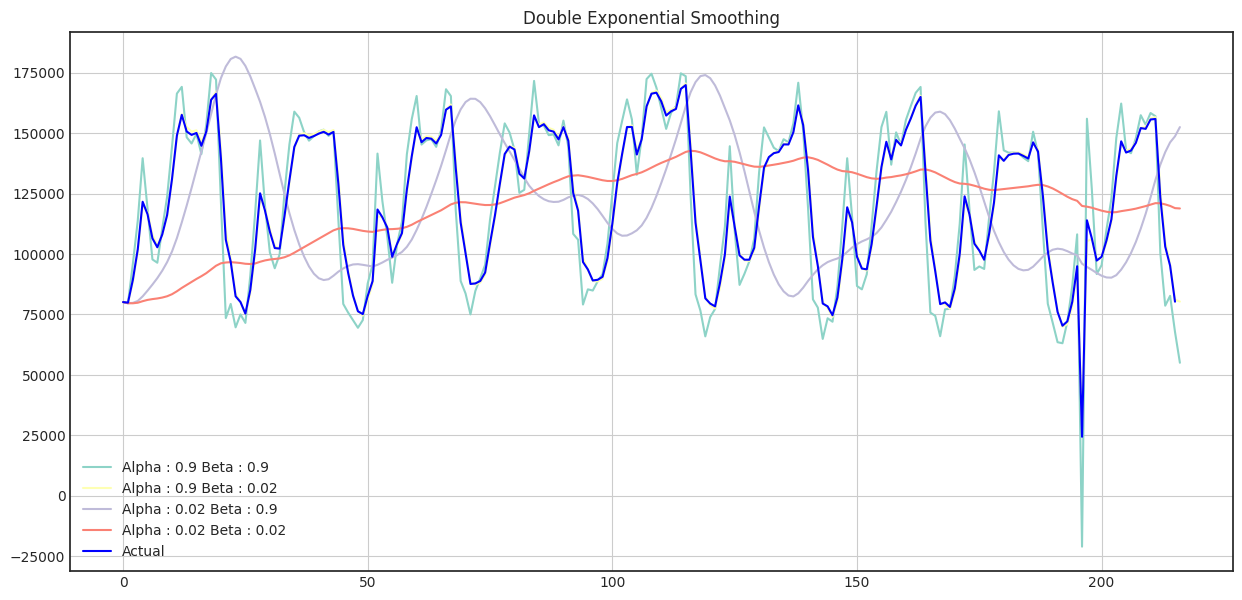

In [39]:
plotDoubleExponentialSmoothing(ads.Ads, alphas = [0.9, 0.02], betas = [0.9, 0.02])

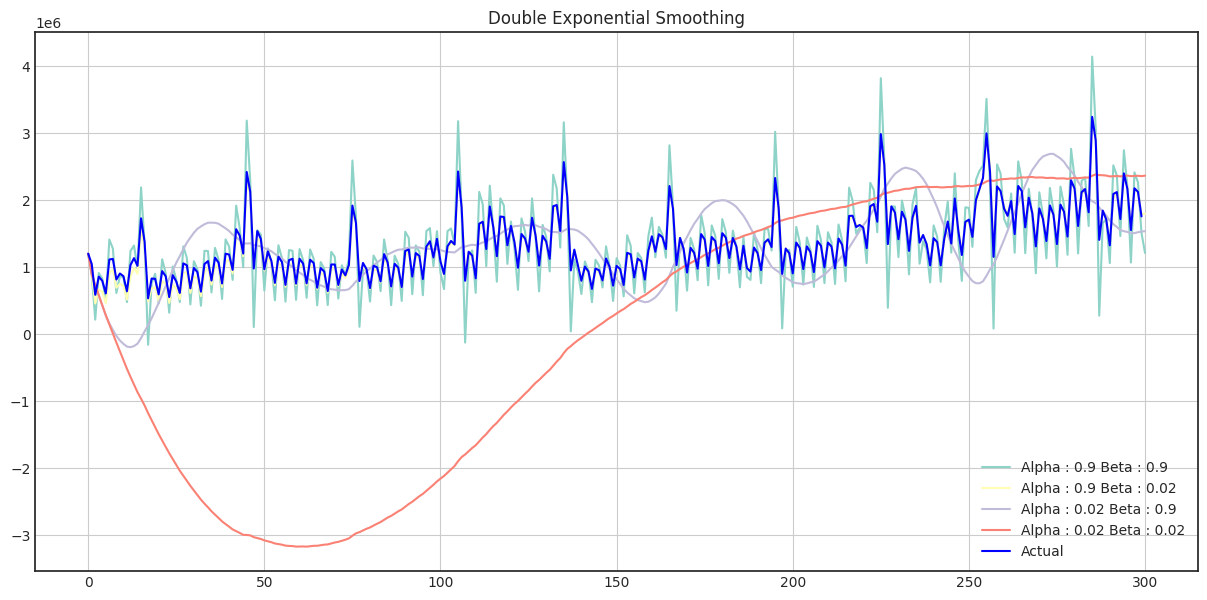

In [40]:
plotDoubleExponentialSmoothing(currency.GEMS_GEMS_SPENT, alphas = [0.9, 0.02], betas = [0.9, 0.02])

# Triple Exponential Smoothening a.k.a Holt-Winters Method

$$\ell_x = \alpha(y_x - s_{x-L}) + (1 - \alpha) (\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1 - \beta) b_{x-1}$$

$$s_x = \gamma(y_x - \ell_x) + (1 - \gamma) s_{x-L}$$

$$\hat{y}_{x+m} = \ell_x + mb_x + s_{x-L+1 + (m-1)modL} $$

Brutlag method for introducing confidence intervals:

$$\hat y_{max_x} = \ell_{x-1} + b_{x-1} + s_{x-T} + m.d_{t-T}$$

$$\hat y_{min_x} = \ell_{x-1} + b_{x-1} + s_{x-T} - m.d_{t-T}$$

$$d_T = \gamma | y_t - \hat y_t|+ (1-\gamma)d_{t-T}$$

T = Length of the season and  d = Predicted deviation


In [ ]:
class HoltWinters:
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor = 1.96):
        self.series = series
        self.slen = slen 
        self.alpha = alpha
        self.beta = beta 
        self.gamma = gamma 
        self.n_preds = n_preds 
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i + self.slen] - self.series[i]) / self.slen
        return sum/self.slen

    def initial_seasonal_components(self):
        seasonals = {}
        seasonal_averages = []
        n_seasons = int(len(self.series)/ self.slen)

        for j in range(n_seasons):
            seasonal_averages.append(sum(self.series[self.slen * j: self.slen * j + self.slen])/float(self.slen))
        
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.9 
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen * j + i] - seasonal_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals